# Chemotaxonomy

Hiearchical clustering of plants based on their chemical composition

### Import modules

In [1]:
from collections import defaultdict
import itertools as itt
import math
from typing import Dict, List
import random

import pandas as pd
from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

# Import taxonomy
from utils import get_genus_and_family_info_for_plants, ncbitaxon_curies_to_names

In [2]:
random.seed(123)

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [4]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [5]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [6]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [7]:
len(plant_chemical_df.chemical_curie.unique()), len(plant_chemical_df.plant_curie.unique())

(87019, 19802)

Convert the SMILEs to PubChem ids

In [8]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_id',
        'smiles',
    ],
)

In [9]:
smiles_df.shape

(89271, 2)

In [10]:
smiles_dict = {}
for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    smiles_dict[pubchem_id] = smiles  

100%|██████████| 89271/89271 [00:00<00:00, 602611.61it/s]


In [11]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89271/89271 [00:00<00:00, 482924.50it/s]


In [12]:
len(smiles_to_pubchem)

87019

### Calculate chemical similarity across all pairs of plants

In [13]:
plant_chem_dict = defaultdict(set)
chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)

100%|██████████| 383591/383591 [00:00<00:00, 420837.21it/s]


Tag chemicals that are present in numerous plants, since they are likely to be common primary metabolites

In [14]:
promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 15
    # Ensure there are no secondary metabolites present in a lot of plants (25)
    # Since they will skew the results for plants that have a lot chemicals compared to others
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

In [15]:
len(promiscuous_chemicals)

4417

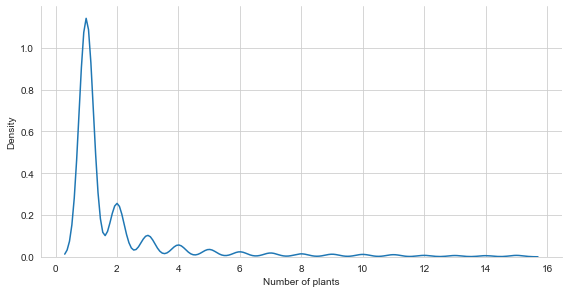

In [16]:
g = sns.displot(
    [
        len(plants)
        for chemical, plants in chemicals_to_plant_dict.items()
        if chemical not in promiscuous_chemicals
    ],
    kind="kde",
    height=4,
    aspect=2,
)

g.set_axis_labels("Number of plants", "Density")
g.set_titles("Distribution of plants per chemical")

plt.show()

Build the similarity matrix

In [17]:
def calculate_overlap_coefficient(
    plant_1,
    plant_2,
    plant_to_chemicals,
):
    """Calculate coeffiencient overlap."""
    chemicals_in_plant_1 = plant_to_chemicals[plant_1]
    chemicals_in_plant_2 = plant_to_chemicals[plant_2]

    return len(
        chemicals_in_plant_1.intersection(chemicals_in_plant_2)
    ) / min([len(chemicals_in_plant_1), len(chemicals_in_plant_2)])

In [18]:
def num_combinations(n, r):
    """Calculate the number of combinations of n choose r."""
    return math.factorial(n) // (math.factorial(r) * math.factorial(n-r))

#### Get the real taxonomical clades (ground truth)

In [19]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    # Get the genus info for plants with enough chemical to evaluate
    {
        plant
        for plant in plant_chem_dict
        if len(plant_chem_dict[plant]) > 25
    }
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 26466.07it/s]


In [20]:
len(genus_to_species), len(family_to_species)

(858, 203)

In [21]:
species_to_genus = {
    plant: genus
    for genus, species in genus_to_species.items()
    if len(species) > 5  # skip genera with only a few plants
    for plant in species
}

species_to_family = {
    plant: family
    for family, species in family_to_species.items()
    if len(species) > 10  # skip family with only a few plants
    for plant in species
}

In [22]:
len(species_to_genus), len(species_to_family)

(247, 1018)

### Populate the similarity matrix

In [23]:
similarity_matrix_path = './similarity_dataframe_scaffold.tsv'

# Get the plants to be evaluated from the full dataset
plant_curies = [
    plant
    for plant in plant_chemical_df.plant_curie.unique()
    if plant in plant_chem_dict and plant in species_to_family
]

# Re order the plants so that they are grouped by family
plant_curies = sorted(plant_curies, key=lambda x: species_to_family[x])

print(f'{len(plant_curies)} plants included in the analysis')

# Create a dataframe to store the similarity matrix
similarity_dataframe_chemicals = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

# Calculate the similarity between all pairs of plants
for plant_1, plant_2 in tqdm(
    itt.combinations_with_replacement(plant_curies, r=2),
    total=num_combinations(len(plant_curies), 2),
):

    sim = calculate_overlap_coefficient(
        plant_1=plant_1,
        plant_2=plant_2,
        plant_to_chemicals=plant_chem_dict,
    )

    # Store the similarity in the dataframe
    similarity_dataframe_chemicals[plant_1][plant_2] = sim
    similarity_dataframe_chemicals[plant_2][plant_1] = sim
    

1018 plants included in the analysis


518671it [01:55, 4508.89it/s]                            


In [24]:
similarity_dataframe_chemicals.shape

(1018, 1018)

Plot distribution of the similarities for the entire dataframe

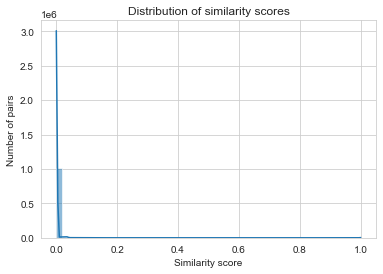

In [25]:
g = sns.histplot(
    similarity_dataframe_chemicals.values.flatten(),
    kde=True,
    bins=50,
)

g.set_xlabel('Similarity score')
g.set_ylabel('Number of pairs')
g.set_title('Distribution of similarity scores')
plt.show()


Scaffold similarity is, as expected, higher, while chemical similarity is quite low (same chemical(s) must be present in two plants)

### Apply hierarchical clustering

In [26]:
def get_cluster_labels(
    similarity_dataframe,
    species_to_genus,
    species_to_family,
    plant_curies,
):
    """Get the cluster labels for a given dataframe."""
    
    # Subset the dataframe for genus
    genus_plants_to_consider = [
        plant
        for plant in similarity_dataframe.index
        if plant in species_to_genus
    ]

    similarity_dataframe_genus_filtered = similarity_dataframe.loc[
        similarity_dataframe.index.isin(genus_plants_to_consider),
        genus_plants_to_consider
    ]

    # Calculate the distance matrix for genus
    distance_matrix_genus = 1 - similarity_dataframe_genus_filtered
    # Calculate the distance matrix for family
    distance_matrix_family = 1 - similarity_dataframe

    # Cluster genus matrix
    clustering_genus = AgglomerativeClustering(
        # Number of genera
        n_clusters=len({
            species_to_genus[plant]
            for plant in plant_curies
            if plant in species_to_genus
        }),
        affinity='precomputed',
        linkage='average',
    )

    clustering_genus.fit(distance_matrix_genus)

    # Cluster family matrix
    clustering_family = AgglomerativeClustering(
        # Number of genera
        n_clusters=len({
            species_to_family[plant]
            for plant in plant_curies
            if plant in species_to_family
        }),
        affinity='precomputed',
        linkage='average',
    )

    clustering_family.fit(distance_matrix_family)

    return (
        clustering_genus.labels_,
        distance_matrix_genus.index,
        clustering_family.labels_,
        distance_matrix_family.index,
    )

In [27]:
# Get the cluster labels for the genus and family for chemicals and scaffolds
predicted_genus_labels_chemicals, genus_label_chemicals, predicted_family_labels_chemicals, family_label_chemicals = get_cluster_labels(
    similarity_dataframe=similarity_dataframe_chemicals,
    species_to_genus=species_to_genus,
    species_to_family=species_to_family,
    plant_curies=plant_curies,
)

Join clusters to actual species assignements 

In [28]:
def prepare_data_for_evaluation(
    labels_pred: np.ndarray,
    species_to_clade: Dict[str, str],
    original_plant_curies: pd.DataFrame,
):
    """Prepare the data for evaluation."""
    ground_truth = []
    predicted_clusters = []

    for cluster, plant in zip(labels_pred, original_plant_curies):
        predicted_clusters.append(cluster)
        ground_truth.append(species_to_clade[plant])
    
    return predicted_clusters, ground_truth


In [29]:

predicted_clusters_genus_chemicals, ground_truth_genus_chemicals = prepare_data_for_evaluation(
    labels_pred=predicted_genus_labels_chemicals,
    species_to_clade=species_to_genus,
    original_plant_curies=genus_label_chemicals,
)

predicted_clusters_family_chemicals, ground_truth_family_chemicals = prepare_data_for_evaluation(
    labels_pred=predicted_family_labels_chemicals,
    species_to_clade=species_to_family,
    original_plant_curies=family_label_chemicals,
)

Number of classes, number of plants evaluated for both genera-clustering and family-clustering analysis

In [30]:
max(predicted_clusters_genus_chemicals), len(predicted_clusters_genus_chemicals), max(predicted_clusters_family_chemicals), len(predicted_clusters_family_chemicals)

(24, 228, 34, 1018)

Evaluation using Adjusted Rand Index
Interpretation:
- The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings
- A value around 0 means it is a random clustering, independently of the numbers of clusters
- A value close to 1 represents a perfect clustering

In [31]:
adjusted_rand_score(predicted_clusters_family_chemicals, ground_truth_family_chemicals)

0.1003120344279961

In [32]:
adjusted_rand_score(predicted_clusters_genus_chemicals, ground_truth_genus_chemicals)

0.5759577671091842

### Visualize the Heatmap for genera

In [33]:
"""Genera matrix"""
genus_plants_to_consider = [
    plant
    for plant in similarity_dataframe_chemicals.index
    if plant in species_to_genus
]

similarity_dataframe_genus_filtered = similarity_dataframe_chemicals.loc[
    similarity_dataframe_chemicals.index.isin(genus_plants_to_consider),
    genus_plants_to_consider
]

# Calculate the distance matrix for genus
distance_matrix_genus = 1 - similarity_dataframe_genus_filtered


# Get the genera (labels) for the subset df
genus_full = [
    species_to_genus[plant]
    for plant in distance_matrix_genus.index
]

"""Subset the dataframe for genus"""
# Get a random subset of 5 genera to zoom in
random_subset_of_genera = random.sample(genus_full, 5)

# Get the plants in the subset
subset = [
    plant
    for plant in distance_matrix_genus.index
    if species_to_genus[plant] in random_subset_of_genera
]

distance_matrix_genus_subset = distance_matrix_genus.loc[
    distance_matrix_genus.index.isin(subset),
    subset,
]

"""Plot a clustermap with dendrogram and colors for classes."""

def prepare_palette(
    taxa: List[str],
):
    """Prepare a color palette for the classes."""
    # Create a color palette
    palette = sns.color_palette('tab10', len(taxa))

    # Create a dictionary to map the classes to the colors
    colors = {c: palette[i] for i, c in enumerate(taxa)}

    # Create a list of colors for the classes
    color_list = [colors[c] for c in taxa]
    return color_list

def prepare_palette_more_than_20(
    taxa: List[str],
):
    # Create a color palette
    palette_1 = sns.color_palette('tab20b', 20)
    palette_2 = sns.color_palette('tab20c', len(taxa) - 20)

    # Create a dictionary to map the classes to the colors
    colors = {}

    for i, c in enumerate(taxa):
        if i < 20:
            colors[c] = palette_1[i]
        else:
            colors[c] = palette_2[i - 20]

    # Create a list of colors for the classes
    return [colors[c] for c in taxa]

# Prepare the color palette for the full matrix
color_list_full = prepare_palette_more_than_20(taxa=genus_full) 

color_list_subset = prepare_palette(taxa=[
    species_to_genus[plant]
    for plant in distance_matrix_genus_subset.index
])

Chemotaxonomy for all genera

/Users/danieldomingo/anaconda3/envs/kg-analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danieldomingo/anaconda3/envs/kg-analysis/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


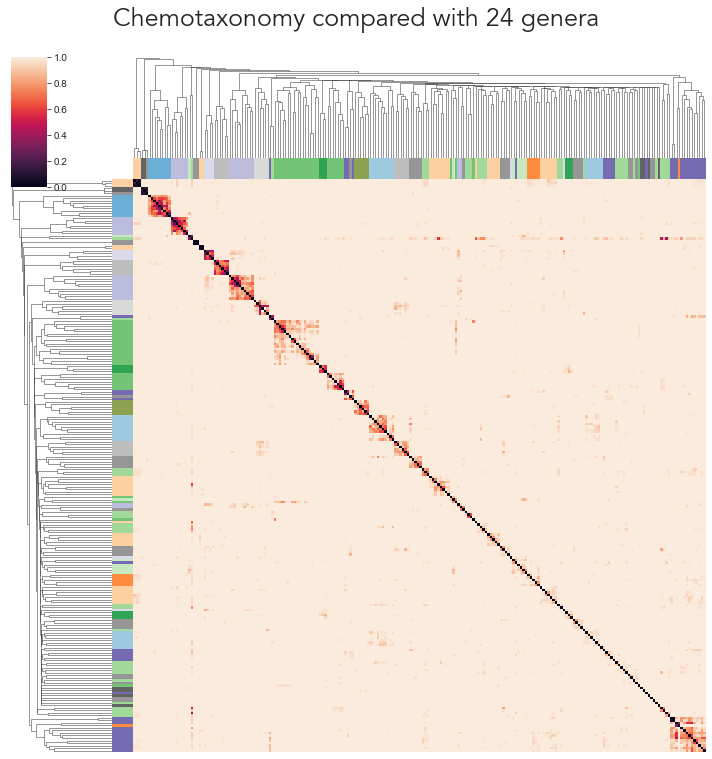

In [34]:
g = sns.clustermap(
    distance_matrix_genus,
    cmap='rocket',
    row_cluster=True,
    col_cluster=True,
    row_colors=color_list_full,
    col_colors=color_list_full,
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=0.15,
)

# Add title and move a bit up with a different font
g.fig.suptitle(
    'Chemotaxonomy compared with 24 genera',
    fontsize=25,
    y=1.05,
    font='Avenir',
)

# Export the figure
g.savefig('chemotaxonomy_genus_full.png', dpi=360)

plt.show()

Subset

In [36]:
plant_to_names_dict = ncbitaxon_curies_to_names(distance_matrix_genus_subset.index)

In [38]:
# Rename all the rows and columns
distance_matrix_genus_subset.rename(
    index=plant_to_names_dict,
    columns=plant_to_names_dict,
    inplace=True,
)

/Users/danieldomingo/anaconda3/envs/kg-analysis/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


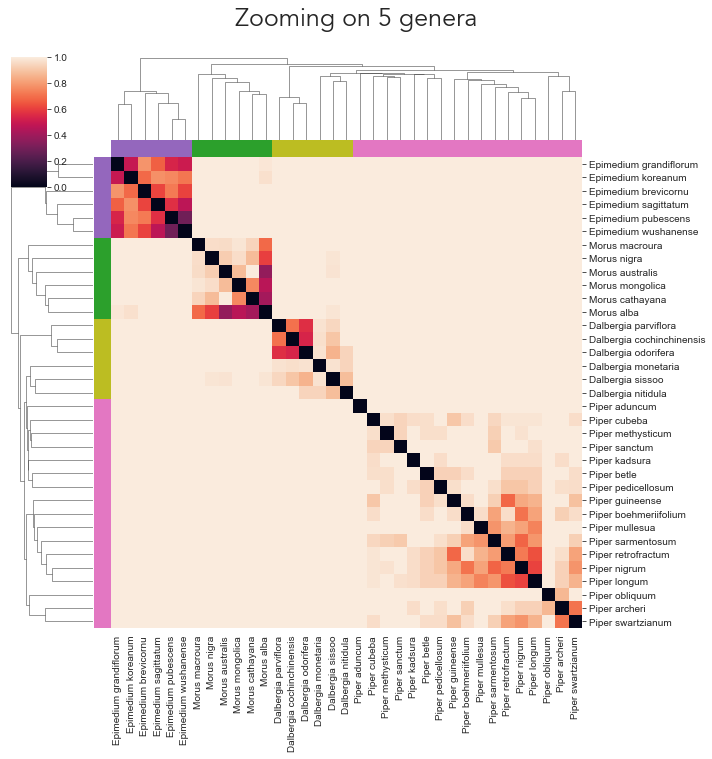

In [39]:
g = sns.clustermap(
    distance_matrix_genus_subset,
    cmap='rocket',
    row_cluster=True,
    col_cluster=True,
    row_colors=color_list_subset,
    col_colors=color_list_subset,
    xticklabels=True,
    yticklabels=True,
    dendrogram_ratio=0.15,
    # Font for labels
     annot_kws={"font": "Avenir"}
)

# Add title and move a bit up with a different font
g.fig.suptitle(
    'Zooming on 5 genera',
    fontsize=25,
    y=1.05,
    font='Avenir',
)

# Export the figure
g.savefig('chemotaxonomy_genus_zoom.png', dpi=360)

plt.show()